In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

import numpy as np
import sys
import io
import re
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# suppress sklearn warnnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
# load and scale data
def load_dataset(dataset_name):
    data = np.load(f'datasets/{dataset_name}.npz')
    scaler = StandardScaler()
    
    dataset = { 'dataset_name': dataset_name }
    dataset['X_train'] = scaler.fit_transform(data['train_X'])
    dataset['y_train'] = data['train_Y']
    
    dataset['X_test'] = scaler.transform(data['test_X'])
    dataset['y_test'] = data['test_Y']
    
    return dataset

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
# input: the verbose output of the fit method
# example to obtain the output
# ============================================
# oldstdout = sys.stdout
# sys.stdout = mystdout = io.StringIO()
# clf.fit(X_train, y_train)
# sys.stdout = oldstdout
# log = mystdout.getvalue()
# ============================================
# output:
#   history: the values of the loss function
#   time: the training time in seconds
def parse_output(log):
    history = [
        float(x)
        for x in re.findall(r'loss:\s+([\d\.]+)', log)
    ]
    m = re.search(r'took\s([\d\.]+)\sseconds', log)
    time = float(m.group(1))
    return history, time

# get average loss from the output of the fit() method
def get_avg_loss(log):
    m = re.search(r'Avg.\sloss:\s([\d\.]+)', log)
    return float(m.group(1))

In [6]:
# train a logistic regression model
# return values:
#   clf: the model
#   history: the training/test accuracy/loss over time
#   total_time: the total training time
def logistic_regression(X_train, y_train, X_test, y_test, \
                        learning_rate, max_iter=1000, tol=1e-4, patience=10):
    clf = SGDClassifier(loss='log', warm_start=True, alpha=0, learning_rate='invscaling', \
                        eta0=learning_rate, max_iter=1, tol=tol, verbose=False)
    history = { metric: [] for metric in ['train_loss', 'test_loss', 'train_acc', 'test_acc'] }
    start_time = time.time()
    for i in range(0, max_iter):
        clf.fit(X_train, y_train)
        train_proba = clf.predict_proba(X_train)
        test_proba = clf.predict_proba(X_test)
        history['train_loss'].append(log_loss(y_train, train_proba))
        history['test_loss'].append(log_loss(y_test, test_proba))
        history['train_acc'].append(clf.score(X_train, y_train))
        history['test_acc'].append(clf.score(X_test, y_test))
        # stop training if no pregress in training loss during the last n=patience iterations
        if i >= patience:
            min_loss = np.min(history['train_loss'][-patience:])
            if history['train_loss'][-(patience+1)] - min_loss < tol:
                break
    end_time = time.time()
    total_time = end_time - start_time
    return clf, history, total_time

In [7]:
# dataset: name of the dataset
def lr_find_eta(dataset_name, X_train, y_train, X_test, y_test):
    etas = [0.1, 0.03, 0.01, 0.003, 0.001]
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f'Dataset: {dataset_name}')
    for i in range(0, len(etas)):
        eta = etas[i]
        clf, history, total_time = logistic_regression(X_train, y_train, X_test, y_test, eta)
        
        num_iter = len(history['train_acc'])
        x = np.arange(0, num_iter) + 1
        
        ax = axes[i]
        ax.plot(x, history['train_loss'], label='Training Loss', color='g')
        ax.plot(x, history['test_loss'], label='Test Loss', color='b')
        ax.set_title(f'$\eta$: {eta}')
        ax.set_xlabel('No. of Epochs')
        ax.set_ylabel('Loss')
    ax.legend()
    fig.savefig(f'lr_{dataset_name}.svg')
    fig.show()

In [8]:
# train a logistic regression model using the found learning rate
def lr_final(dataset_name, X_train, y_train, X_test, y_test, eta):
    clf, history, total_time = logistic_regression(X_train, y_train, X_test, y_test, eta)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Dataset: {dataset_name}; $\eta$: {eta}')

    num_iter = len(history['train_acc'])
    x = np.arange(0, num_iter) + 1

    ax1.plot(x, history['train_loss'], label='Training Loss', color='g')
    ax1.plot(x, history['test_loss'], label='Test Loss', color='b')
    ax1.set_xlabel('No. of Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(x, history['train_acc'], label='Training Accuracy', color='g')
    ax2.plot(x, history['test_acc'], label='Test Accuracy', color='b')
    y_max = np.max(history['train_acc'])
    y_min = np.min(history['test_acc'])
    ax2.set_ylim((y_min - 0.1, y_max + 0.1))
    ax2.set_xlabel('No. of Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    fig.savefig(f'lr-final-{dataset_name}.svg')
    fig.show()
    
    print(f'Dataset: {dataset_name}')
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    train_proba = clf.predict_proba(X_train)
    test_proba = clf.predict_proba(X_test)
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    print(f'Training accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}')
    print(f'Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}')
    print('Confusion matrix: ')
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)
    print(confusion_matrix(y_test, y_test_pred))
    auc = roc_auc_score(y_test, y_test_proba[:,1])
    print(f'AUC: {auc:.3f}\n')

In [9]:
# perform training once
# return values:
#   clf: the classifier
#   history: the training/test accurary/loss during training
#   total_time: the total training time
def neural_network(X_train, y_train, X_test, y_test, \
                   H, eta, max_iter=3000, tol=1e-4, patience=10):
    clf = MLPClassifier(hidden_layer_sizes=(H, ), activation='logistic', \
                        solver='sgd', learning_rate='adaptive', learning_rate_init=eta, \
                       max_iter=1, tol=tol, verbose=False, warm_start=True)
    history = { metric: [] for metric in ['train_loss', 'test_loss', 'train_acc', 'test_acc'] }
    start_time = time.time()
    for i in range(0, max_iter):
        clf.fit(X_train, y_train)
        # the probabilities of being in class 1
        train_proba = clf.predict_proba(X_train)
        test_proba = clf.predict_proba(X_test)
        history['train_loss'].append(log_loss(y_train, train_proba))
        history['test_loss'].append(log_loss(y_test, test_proba))
        history['train_acc'].append(clf.score(X_train, y_train))
        history['test_acc'].append(clf.score(X_test, y_test))
        # stop training if no pregress in training loss during the last n=patience iterations
        if i >= patience:
            min_loss = np.min(history['train_loss'][-patience:])
            if history['train_loss'][-(patience+1)] - min_loss < tol:
                break
    end_time = time.time()
    total_time = end_time - start_time
    return clf, history, total_time

In [10]:
# use cross validation to find the optimal number of units in the hidden layer
def nn_cv(dataset_name, X_train, y_train, eta=1e-3, max_iter=3000, tol=1e-4):
    Hs = range(1, 11)
    avg_acc = []
    for H in Hs:
        clf = MLPClassifier(hidden_layer_sizes=(H, ), activation='logistic', \
                            solver='sgd', learning_rate='adaptive', learning_rate_init=eta, \
                            max_iter=max_iter, tol=tol)
        cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        scores = cross_val_score(clf, X_train, y_train, cv=cv)
        avg_acc.append(np.mean(scores))

    plt.plot(Hs, avg_acc)
    plt.title(f'Dataset: {dataset_name}, $\eta$: {eta}')
    plt.xlabel('H')
    plt.ylabel('Avg. accuracy')
    plt.savefig(f'nn-cv-{dataset_name}.svg')
    plt.show()

In [11]:
# train a Neural Network model using the H found in cross validation
def nn_final(dataset_name, X_train, y_train, X_test, y_test, H, eta):
    clf, history, total_time = neural_network(X_train, y_train, X_test, y_test, H, eta, max_iter=3000)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Dataset: {dataset_name}, H: {H}, $\eta$: {eta}')

    num_iter = len(history['train_acc'])
    x = np.arange(0, num_iter) + 1

    ax1.plot(x, history['train_loss'], label='Training Loss', color='g')
    ax1.plot(x, history['test_loss'], label='Test Loss', color='b')
    ax1.set_xlabel('No. of Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(x, history['train_acc'], label='Training Accuracy', color='g')
    ax2.plot(x, history['test_acc'], label='Test Accuracy', color='b')
    y_max = np.max(history['train_acc'])
    y_min = np.min(history['test_acc'])
    ax2.set_ylim((y_min - 0.1, y_max + 0.1))
    ax2.set_xlabel('No. of Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    fig.savefig(f'nn-final-{dataset_name}.svg')
    fig.show()
    
    print(f'Dataset: {dataset_name}, H = {H}')
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    train_proba = clf.predict_proba(X_train)
    test_proba = clf.predict_proba(X_test)
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    print(f'Training accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}')
    print(f'Training loss: {train_loss:.3f}, Test loss: {test_loss:.3f}')
    print('Confusion matrix: ')
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)
    print(confusion_matrix(y_test, y_test_pred))
    auc = roc_auc_score(y_test, y_test_proba[:,1])
    print(f'AUC: {auc:.3f}\n')

In [12]:
# train a linear SVM model
def svm_linear(dataset_name, X_train, y_train, X_test, y_test):
    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)
    train_proba = clf.predict_proba(X_train)
    test_proba = clf.predict_proba(X_test)
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    
    print(f'Dataset: {dataset_name}')
    print(f'Train Loss = {train_loss:.3f}, Test Loss = {test_loss:.3f}')
    print(f'Training Accuracy = {train_acc:.3f}, Test Accuracy = {test_acc:.3f}')
    print('Confusion matrix: ')
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)
    print(confusion_matrix(y_test, y_test_pred))
    auc = roc_auc_score(y_test, y_test_proba[:,1])
    print(f'AUC: {auc:.3f}\n')

In [13]:
# for the cross validation of SVM with RBF kernel
def svm_rbf_cv(dataset_name, X_train, y_train):
    gammas = [0.001, 0.01, 0.1, 1]
    avg_acc = []
    for gamma in gammas:
        clf = SVC(kernel='rbf', gamma=gamma)
        cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
        scores = cross_val_score(clf, X_train, y_train, cv=cv)
        #print(scores)
        avg_acc.append(np.mean(scores))
    plt.plot(gammas, avg_acc)
    plt.title(f'Dataset: {dataset_name}')
    plt.xlabel('$\gamma$')
    plt.xscale('log')
    plt.ylabel('Avg. accuracy')
    plt.savefig(f'rbf-cv-{dataset_name}.svg')
    plt.show()

In [14]:
# train a SVM model with RBF kernel using the found gamma
def svm_rbf_final(dataset_name, X_train, y_train, X_test, y_test, gamma):
    clf = SVC(kernel='rbf', gamma=gamma, probability=True)
    clf.fit(X_train, y_train)
    train_proba = clf.predict_proba(X_train)
    test_proba = clf.predict_proba(X_test)
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    
    print(f'Dataset: {dataset_name}, gamma = {gamma}')
    print(f'Train Loss = {train_loss:.3f}, Test Loss = {test_loss:.3f}')
    print(f'Training Accuracy = {train_acc:.3f}, Test Accuracy = {test_acc:.3f}')
    print('Confusion matrix: ')
    y_test_pred = clf.predict(X_test)
    y_test_proba = clf.predict_proba(X_test)
    print(confusion_matrix(y_test, y_test_pred))
    auc = roc_auc_score(y_test, y_test_proba[:,1])
    print(f'AUC: {auc:.3f}\n')

In [15]:
# load datasets
datasets = [
    load_dataset(dataset_name)
    for dataset_name in ['breast-cancer', 'diabetes', 'digit', 'iris', 'wine']
]

## Logistic Regression

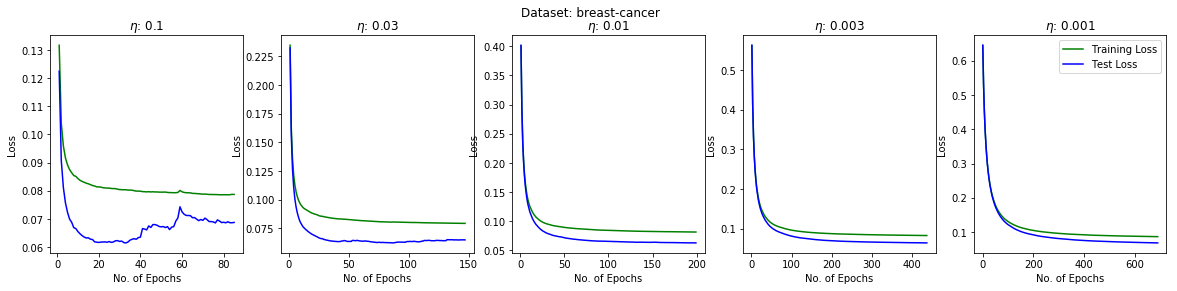

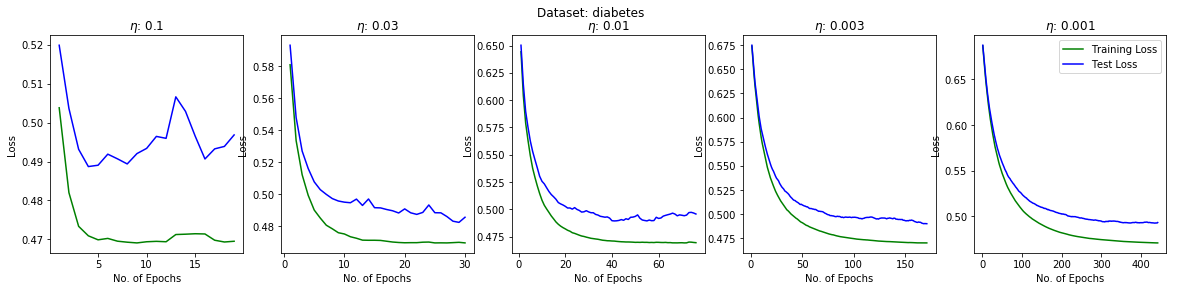

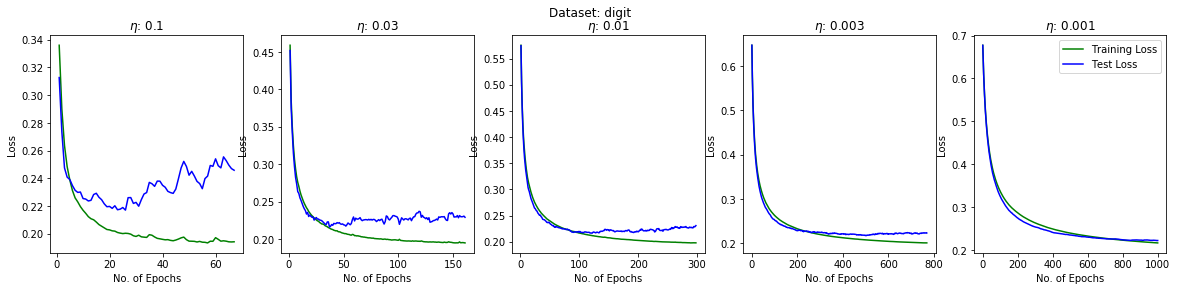

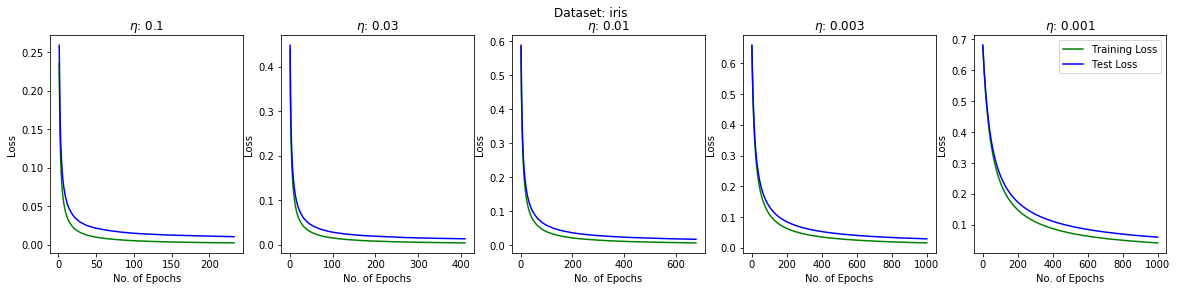

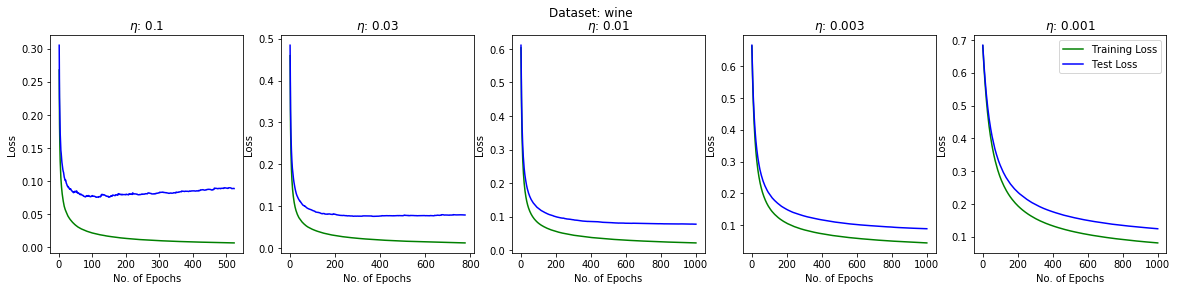

In [16]:
# find a learning rate that leads to convergence
for dataset in datasets:
    lr_find_eta(**dataset)

$\eta = 0.001$ leads to stable convergence on all datasets, so we select $\eta=0.001$

Dataset: breast-cancer
Training accuracy: 0.971, Test accuracy: 0.978
Training loss: 0.087, Test loss: 0.068
Confusion matrix: 
[[47  1]
 [ 2 86]]
AUC: 0.997

Dataset: diabetes
Training accuracy: 0.769, Test accuracy: 0.784
Training loss: 0.471, Test loss: 0.493
Confusion matrix: 
[[34 20]
 [13 86]]
AUC: 0.817

Dataset: digit
Training accuracy: 0.921, Test accuracy: 0.915
Training loss: 0.217, Test loss: 0.221
Confusion matrix: 
[[ 83   8]
 [  9 100]]
AUC: 0.973

Dataset: iris
Training accuracy: 1.000, Test accuracy: 1.000
Training loss: 0.041, Test loss: 0.059
Confusion matrix: 
[[10  0]
 [ 0 20]]
AUC: 1.000

Dataset: wine
Training accuracy: 0.993, Test accuracy: 0.972
Training loss: 0.081, Test loss: 0.124
Confusion matrix: 
[[22  0]
 [ 1 13]]
AUC: 1.000



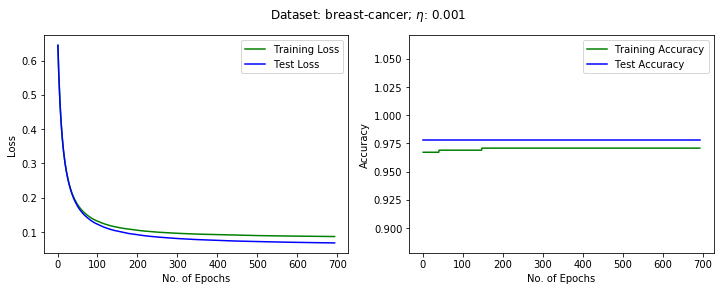

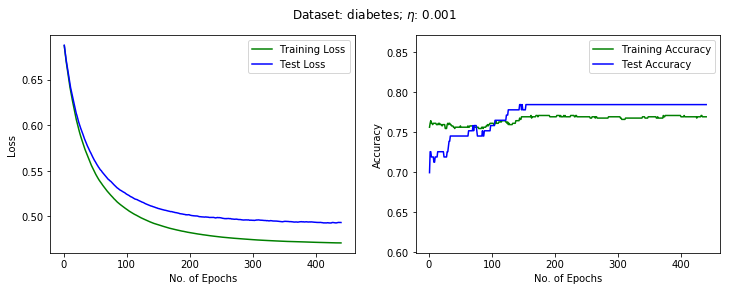

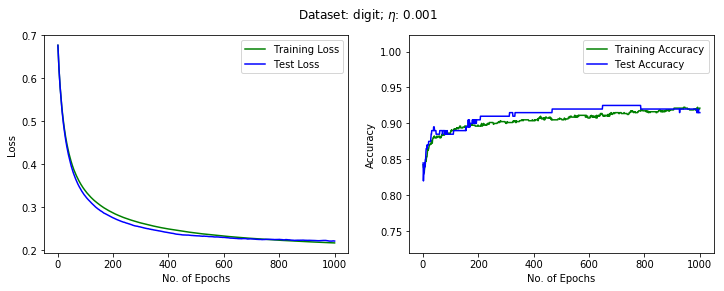

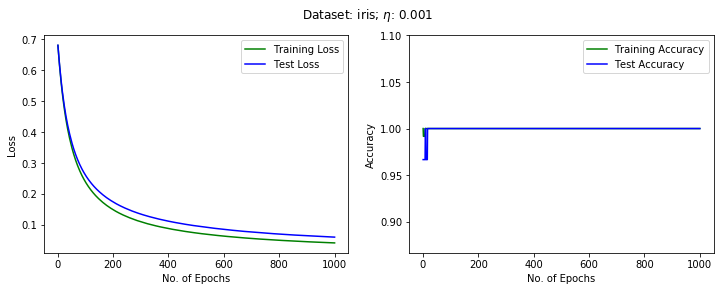

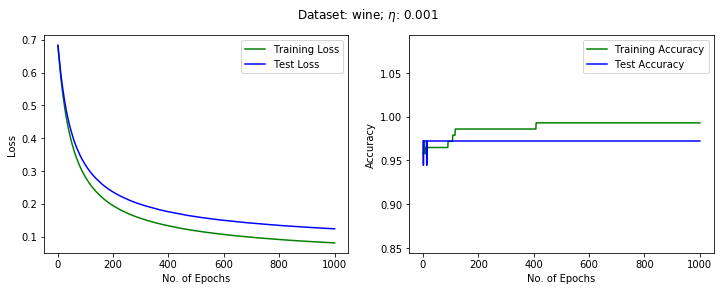

In [17]:
# build and train logistic regression models using eta = 0.001
for dataset in datasets:
    lr_final(**dataset, eta=0.001)

## Neural Network

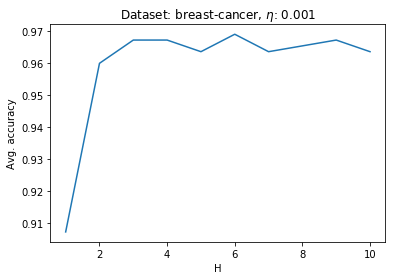

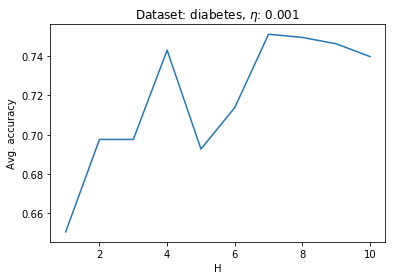

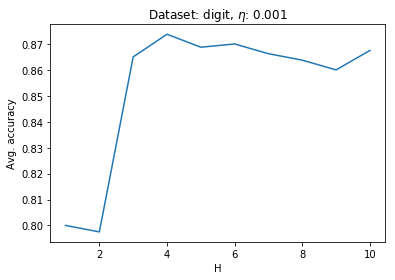

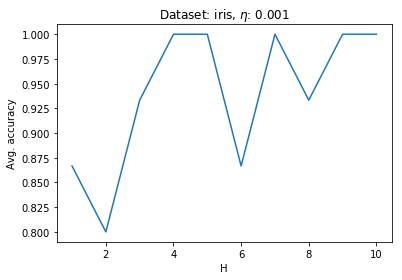

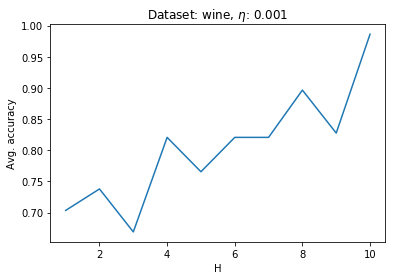

In [18]:
# build neural network models and tune the paramter using cross validation
# we set the learning rate to be 0.001 and find it leads to stable convergence 
for dataset in datasets:
    dataset_name = dataset['dataset_name']
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    nn_cv(dataset_name, X_train, y_train)

Dataset: breast-cancer, H = 2
Training accuracy: 0.969, Test accuracy: 0.978
Training loss: 0.148, Test loss: 0.141
Confusion matrix: 
[[47  1]
 [ 2 86]]
AUC: 0.998

Dataset: diabetes, H = 8
Training accuracy: 0.756, Test accuracy: 0.758
Training loss: 0.502, Test loss: 0.518
Confusion matrix: 
[[28 26]
 [11 88]]
AUC: 0.810

Dataset: digit, H = 3
Training accuracy: 0.905, Test accuracy: 0.915
Training loss: 0.268, Test loss: 0.263
Confusion matrix: 
[[85  6]
 [11 98]]
AUC: 0.968

Dataset: iris, H = 5
Training accuracy: 1.000, Test accuracy: 1.000
Training loss: 0.139, Test loss: 0.155
Confusion matrix: 
[[10  0]
 [ 0 20]]
AUC: 1.000

Dataset: wine, H = 8
Training accuracy: 0.986, Test accuracy: 0.944
Training loss: 0.176, Test loss: 0.239
Confusion matrix: 
[[22  0]
 [ 2 12]]
AUC: 0.997



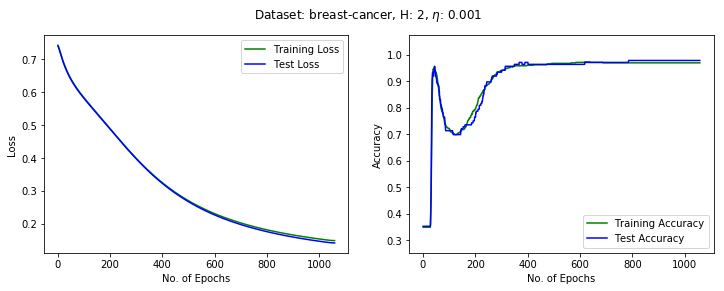

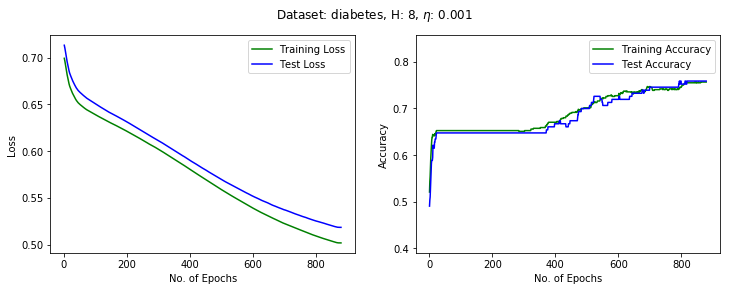

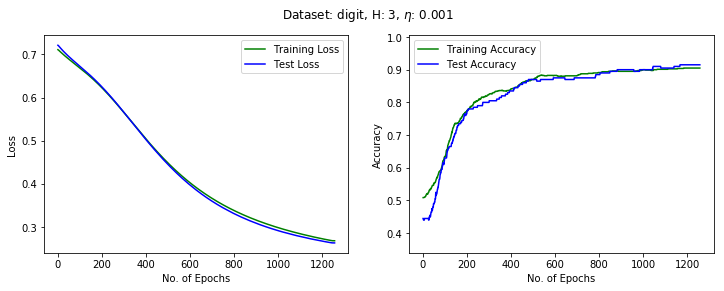

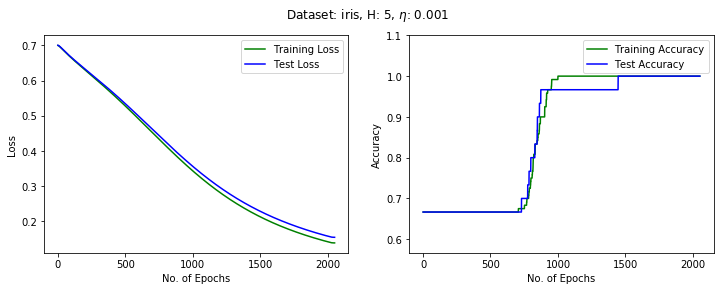

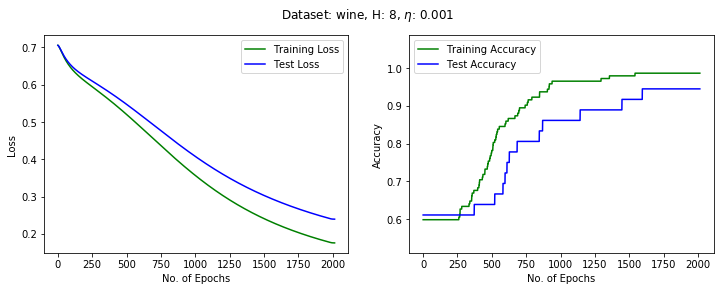

In [19]:
# train neural network models using the found H
# compute the loss/accuracy of both training and test sets
# NOTE: the optimal H obtained by cross validation
# might change slightly every time because of the randomization issue
Hs = [2, 8, 3, 5, 8]
for dataset, H in zip(datasets, Hs):
    nn_final(**dataset, H=H, eta=1e-3)

## SVM with linear kernel

In [20]:
# build and train SVM models with linear kernel
# show the loss/accuracy of both training and test sets
for dataset in datasets:
    svm_linear(**dataset)

Dataset: breast-cancer
Train Loss = 0.087, Test Loss = 0.074
Training Accuracy = 0.971, Test Accuracy = 0.971
Confusion matrix: 
[[46  2]
 [ 2 86]]
AUC: 0.998

Dataset: diabetes
Train Loss = 0.472, Test Loss = 0.498
Training Accuracy = 0.761, Test Accuracy = 0.784
Confusion matrix: 
[[35 19]
 [14 85]]
AUC: 0.816

Dataset: digit
Train Loss = 0.228, Test Loss = 0.240
Training Accuracy = 0.926, Test Accuracy = 0.925
Confusion matrix: 
[[86  5]
 [10 99]]
AUC: 0.970

Dataset: iris
Train Loss = 0.021, Test Loss = 0.035
Training Accuracy = 1.000, Test Accuracy = 1.000
Confusion matrix: 
[[10  0]
 [ 0 20]]
AUC: 1.000

Dataset: wine
Train Loss = 0.041, Test Loss = 0.124
Training Accuracy = 1.000, Test Accuracy = 0.944
Confusion matrix: 
[[22  0]
 [ 2 12]]
AUC: 0.997



## SVM with RBF kernel

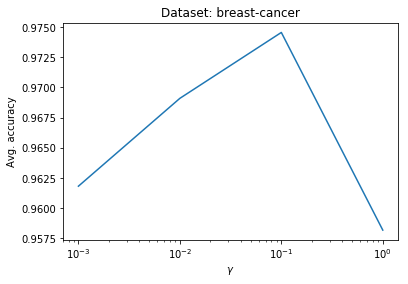

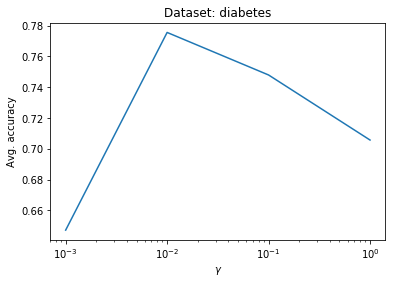

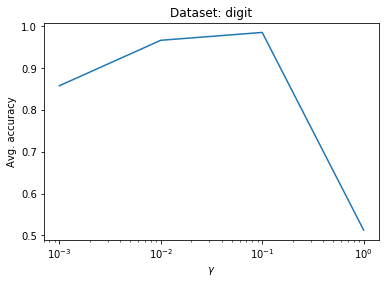

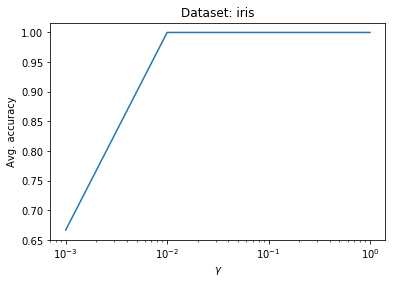

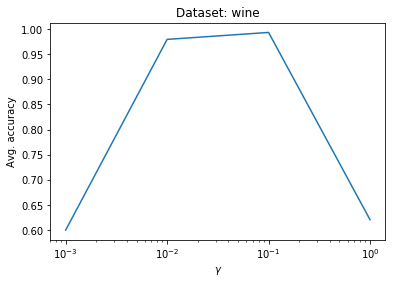

In [21]:
# tune the parameters using cross validation
for dataset in datasets:
    dataset_name = dataset['dataset_name']
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    svm_rbf_cv(dataset_name, X_train, y_train)

In [22]:
# train the SVM models with RBF kernel using the found gammas
gammas = [0.1, 0.01, 0.1, 0.01, 0.1]
for dataset, gamma in zip(datasets, gammas):
    svm_rbf_final(**dataset, gamma=gamma)

Dataset: breast-cancer, gamma = 0.1
Train Loss = 0.076, Test Loss = 0.081
Training Accuracy = 0.974, Test Accuracy = 0.978
Confusion matrix: 
[[47  1]
 [ 2 86]]
AUC: 0.994

Dataset: diabetes, gamma = 0.01
Train Loss = 0.463, Test Loss = 0.493
Training Accuracy = 0.777, Test Accuracy = 0.778
Confusion matrix: 
[[32 22]
 [12 87]]
AUC: 0.815

Dataset: digit, gamma = 0.1
Train Loss = 0.000, Test Loss = 0.045
Training Accuracy = 1.000, Test Accuracy = 0.980
Confusion matrix: 
[[ 89   2]
 [  2 107]]
AUC: 0.999

Dataset: iris, gamma = 0.01
Train Loss = 0.018, Test Loss = 0.029
Training Accuracy = 1.000, Test Accuracy = 1.000
Confusion matrix: 
[[10  0]
 [ 0 20]]
AUC: 1.000

Dataset: wine, gamma = 0.1
Train Loss = 0.007, Test Loss = 0.085
Training Accuracy = 1.000, Test Accuracy = 0.972
Confusion matrix: 
[[22  0]
 [ 1 13]]
AUC: 0.997

